# Testing Images Benchmarks - WGAN-QC Solver
DenseICNN-based benchmark training.
**GPU-only implementation.**

In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import gc

import pandas as pd

from sklearn.decomposition import PCA

from src import distributions

from src.icnn import FakeResNet64_D
from src.tools import train_identity_map, unfreeze, freeze
from src.plotters import plot_benchmark_emb, plot_W2, plot_benchmark_images, plot_benchmark_metrics
import src.map_benchmark as mbm
from src.metrics import score_fitted_maps, score_baseline_maps, metrics_to_dict

from tqdm import tqdm
from IPython.display import clear_output

## Changable Config

In [2]:
BATCH_SIZE = 64
WHICH = 'Early'

GPU_DEVICE = 3

## Hardcoded Config

In [4]:
BENCHMARK = 'CelebA64'

MAX_ITER = 20001
LR = 3 * 1e-4
DIM = 64 * 64 * 3

OUTPUT_PATH = '../logs/' + BENCHMARK
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

METHOD = 'QC'

assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)
torch.manual_seed(0x000000); np.random.seed(0x000000)

## Benchmark Setup

In [5]:
benchmark = mbm.CelebA64Benchmark(which=WHICH, batch_size=BATCH_SIZE)
emb_X = PCA(n_components=2).fit(benchmark.input_sampler.sample(2**14).cpu().detach().numpy())
emb_Y = PCA(n_components=2).fit(benchmark.output_sampler.sample(2**14).cpu().detach().numpy())

## WGAN-QC solver setup

In [6]:
from cvxopt import matrix, spmatrix, sparse, solvers
import torch.nn.functional as F
import torch.autograd as autograd

K = 1.
gamma = 0.1
Kr = np.sqrt(K)
LAMBDA = 2 * Kr * gamma * 2

solvers.options['show_progress'] = False
solvers.options['glpk'] = {'msg_lev': 'GLP_MSG_OFF'}

A = spmatrix(1.0, range(BATCH_SIZE), [0]*BATCH_SIZE, (BATCH_SIZE,BATCH_SIZE))
for i in range(1,BATCH_SIZE):
    Ai = spmatrix(1.0, range(BATCH_SIZE), [i]*BATCH_SIZE, (BATCH_SIZE,BATCH_SIZE))
    A = sparse([A,Ai])

D_ = spmatrix(-1.0, range(BATCH_SIZE), range(BATCH_SIZE), (BATCH_SIZE,BATCH_SIZE))
DM = D_
for i in range(1,BATCH_SIZE):
    DM = sparse([DM, D_])

A = sparse([[A],[DM]])

cr = matrix([-1.0/BATCH_SIZE]*BATCH_SIZE)
cf = matrix([1.0/BATCH_SIZE]*BATCH_SIZE)
c = matrix([cr,cf])

pStart = {}
pStart['x'] = matrix([matrix([1.0]*BATCH_SIZE),matrix([-1.0]*BATCH_SIZE)])
pStart['s'] = matrix([1.0]*(2*BATCH_SIZE))

def comput_dist(Y, X):
    num_r, num_f = Y.size(0), X.size(0)
    Y3D = Y.view(num_r, -1).unsqueeze(1).expand(num_r, num_f, DIM)
    X3D = X.view(num_f, -1).unsqueeze(0).expand(num_r, num_f, DIM)
    dist = 0.5 * K *(Y3D - X3D).pow(2).sum(2).squeeze()
    return dist

def Wasserstein_LP(dist):
    b = matrix(dist.cpu().detach().double().numpy().flatten())
    sol = solvers.lp(c, A, b, primalstart=pStart, solver='glpk')
    offset = 0.5 * (sum(sol['x'])) / BATCH_SIZE
    sol['x'] = sol['x'] - offset
    pStart['x'], pStart['s'] = sol['x'], sol['s']
    return sol

def approx_OT(sol):
    ResMat = np.array(sol['z']).reshape((BATCH_SIZE, BATCH_SIZE))
    return torch.from_numpy(np.argmax(ResMat, axis=0)).long().cuda()

def OT_regularization(output_X, X, RF_dif):
    output_X_grad = torch.ones(output_X.size()).cuda()
    gradients = autograd.grad(outputs=output_X, inputs=X,
                              grad_outputs=output_X_grad,
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    n = gradients.size(0)    
    RegLoss = 0.5 * ((gradients.view(n, -1).norm(dim=1) / (2*Kr) - Kr/2 * RF_dif.view(n, -1).norm(dim=1)).pow(2)).mean()
    X.requires_grad = False
    return RegLoss

def wgan_qc_loss(X, Y, D):
    dist = comput_dist(Y, X)
    dist = dist
    sol = Wasserstein_LP(dist)
    mapping = approx_OT(sol)
    Y_ordered = Y[mapping]
    RF_dif = Y_ordered - X

    # construct target
    target = torch.from_numpy(np.array(sol['x'])).float()
    target = target.squeeze().cuda()

    output_Y = K * (D(Y) - (Y ** 2).sum(dim=1, keepdims=True) / 2)
    output_X = K * (D(X) - (X ** 2).sum(dim=1, keepdims=True) / 2)
    output_Y, output_X = output_Y.squeeze(), output_X.squeeze()

    output_Y_mean = output_Y.mean(0).view(1)
    output_X_mean = output_X.mean(0).view(1)

    L2LossD_Y = F.mse_loss(output_Y_mean[0], target[:BATCH_SIZE].mean())
    L2LossD_X = F.mse_loss(output_X, target[BATCH_SIZE:])
    L2LossD = 0.5 * L2LossD_Y + 0.5 * L2LossD_X 

    RegLossD = OT_regularization(output_X, X, RF_dif)
    Loss = L2LossD + LAMBDA * RegLossD
    with torch.no_grad():
        loss_nograd = -((X ** 2).sum(dim=1).mean() / 2 + (Y ** 2).sum(dim=1).mean() / 2 -\
        (Y_ordered * X).sum(dim=1).mean()).item()
    return Loss, loss_nograd

## Discriminators Setup

22933441 trainable parameters in Discriminative Network
22933441 params in D_conj Network
Training the potentials to satisfy push(x)=x



Pretraining identity potential. Final MSE: 3.185275307404645e-11


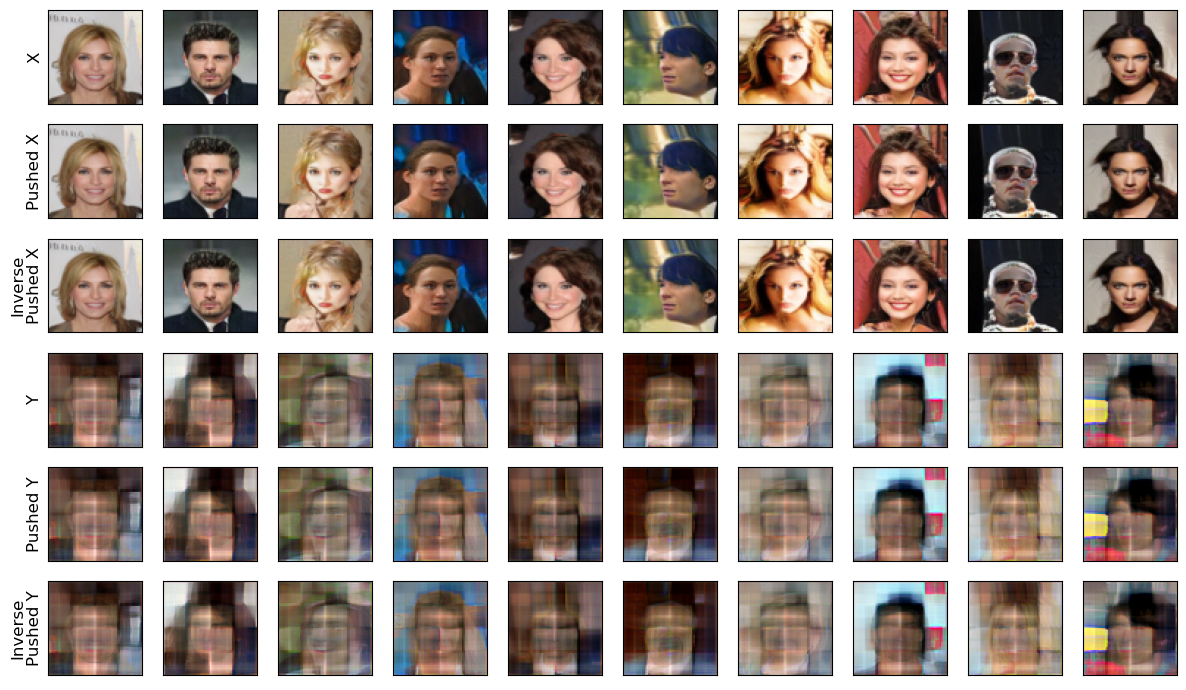

In [7]:
D = FakeResNet64_D().cuda()
D_conj = FakeResNet64_D().cuda()

print(np.sum([np.prod(list(p.shape)) for p in D.parameters()]), 'trainable parameters in Discriminative Network')
print(np.sum([np.prod(list(p.shape)) for p in D_conj.parameters() if p.requires_grad]), 'params in D_conj Network')

pretrain_sampler = distributions.CubeUniformSampler(DIM, centered=True)
print(
    'Pretraining identity potential. Final MSE:',
    train_identity_map(D, pretrain_sampler, BATCH_SIZE, max_iter=1000, tol=1e-3, blow=4, convex=False, verbose=True)
)
D_conj.load_state_dict(D.state_dict())

del pretrain_sampler

fig, axes = plot_benchmark_images(benchmark, D, D_conj)

## Main training

In [8]:
D_opt = torch.optim.Adam(D.parameters(), lr=LR)
D_conj_opt = torch.optim.Adam(D_conj.parameters(), lr=LR)

In [9]:
W2_history = []
metrics = dict(L2_UVP_fwd=[], cos_fwd=[], L2_UVP_inv=[], cos_inv=[])
baselines = {
    baseline : metrics_to_dict(*score_baseline_maps(benchmark, baseline))
    for baseline in ['identity', 'constant']
}

Iteration 20000


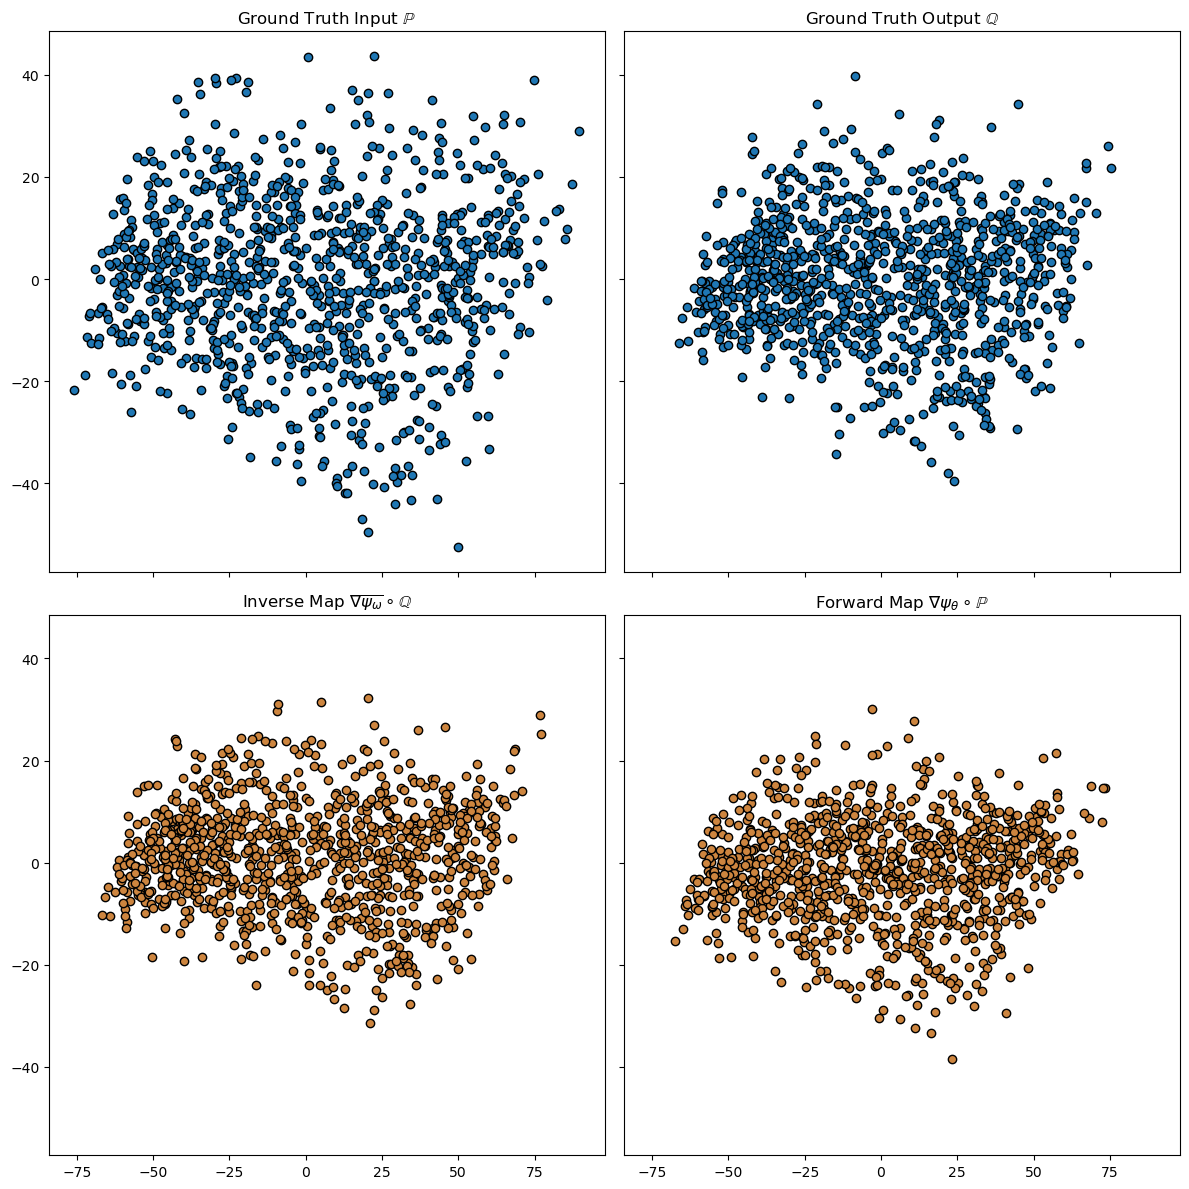

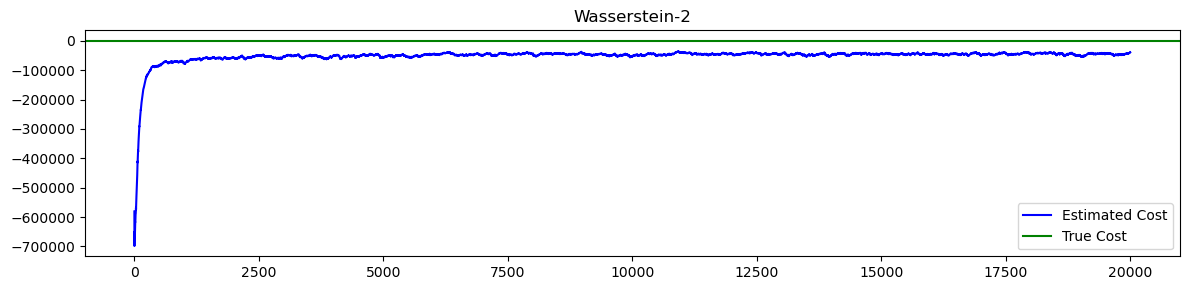

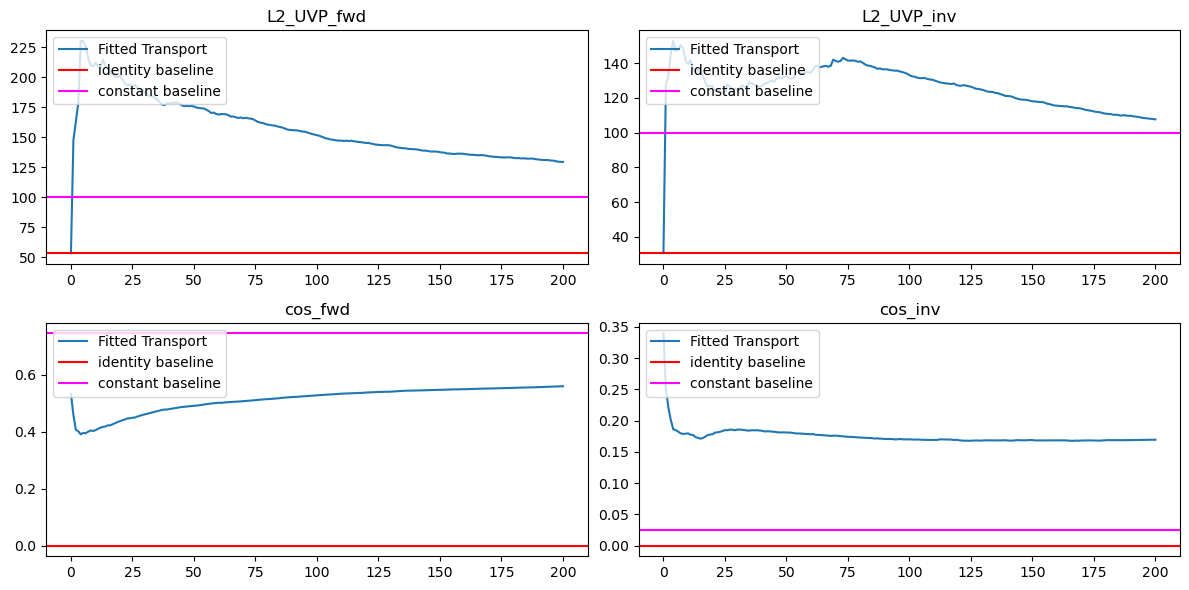

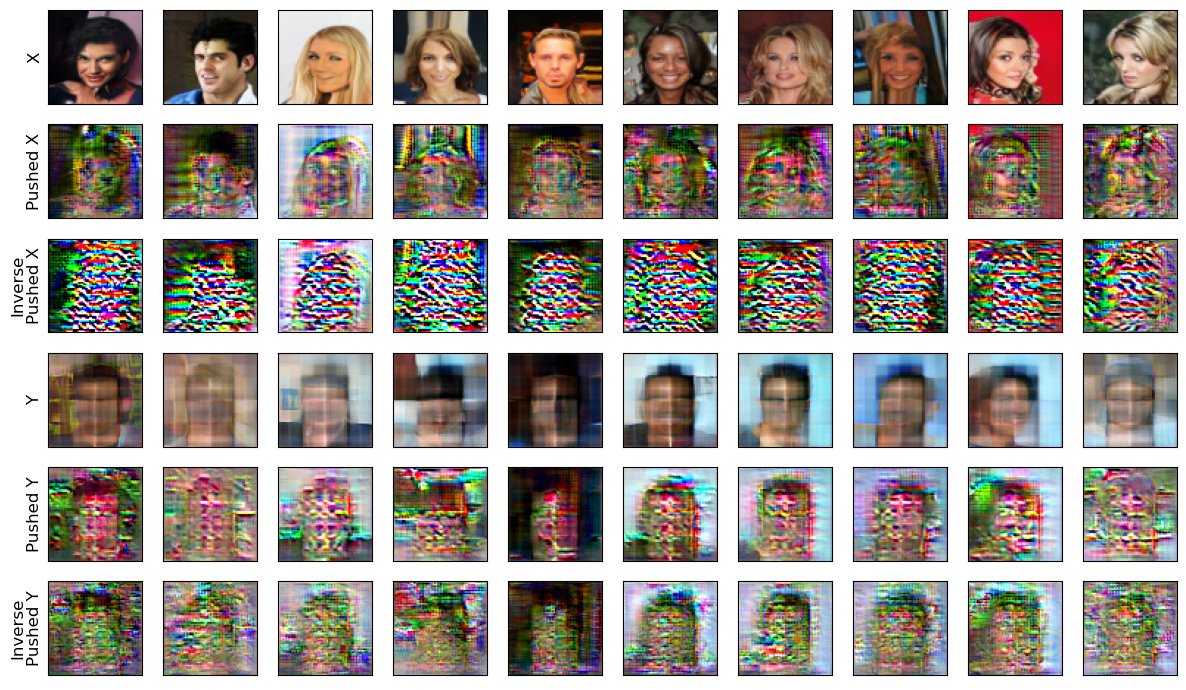

100%|█████████████████████████████████████████████████████████████████████████████████████████| 20001/20001 [18:01:27<00:00,  3.24s/it]


In [10]:

for iteration in tqdm(range(MAX_ITER)):
    unfreeze(D); unfreeze(D_conj)
    
    X = benchmark.input_sampler.sample(BATCH_SIZE)
    X.requires_grad_(True)
    Y = benchmark.output_sampler.sample(BATCH_SIZE)
    Y.requires_grad_(True)
    
    Loss_XY, loss_nograd_XY = wgan_qc_loss(X, Y, D)
    Loss_XY.backward()
    D_opt.step(); D_opt.zero_grad()
    
    Loss_YX, loss_nograd_YX = wgan_qc_loss(Y, X, D_conj)
    Loss_YX.backward()   
    D_conj_opt.step(); D_conj_opt.zero_grad()
    
    W2_history.append(-((Loss_XY + loss_nograd_XY + Loss_YX + loss_nograd_YX) / 2.).item())
    
    if iteration % 100 == 0:
        L2_UVP_fwd, cos_fwd, L2_UVP_inv, cos_inv = score_fitted_maps(benchmark, D, D_conj)        
        metrics['L2_UVP_fwd'].append(L2_UVP_fwd); metrics['cos_fwd'].append(cos_fwd)
        metrics['L2_UVP_inv'].append(L2_UVP_inv); metrics['cos_inv'].append(cos_inv)
                    
    if iteration % 1000 == 0:
        clear_output(wait=True)
        print("Iteration", iteration)
        
        fig, axes = plot_benchmark_emb(benchmark, emb_X, emb_Y, D, D_conj)
        plt.show(fig); plt.close(fig)
        
        fig, axes = plot_W2(benchmark, W2_history)
        plt.show(fig); plt.close(fig)
        
        fig, axes = plot_benchmark_metrics(benchmark, metrics, baselines)
        plt.show(fig); plt.close(fig)
        
        fig, axes = plot_benchmark_images(benchmark, D, D_conj)
        plt.show(fig); plt.close(fig)

In [11]:
print(f'Logging Metrics Evolution to {OUTPUT_PATH}')
results = pd.DataFrame(metrics)
results.to_csv(os.path.join(OUTPUT_PATH, f'{WHICH}-{METHOD}.csv'))
torch.save(D.state_dict(), os.path.join(OUTPUT_PATH, f'{WHICH}-{METHOD}.pt'))
torch.save(D_conj.state_dict(), os.path.join(OUTPUT_PATH, f'{WHICH}-{METHOD}_conj.pt'))
print('Done!')

Logging Metrics Evolution to ../logs/CelebA64
Done!
